# Деревья решений

Подробнее про [bias-variance tradeoff](https://cold-scallion-5b8.notion.site/Underfitting-overfitting-bias-variance-tradeoff-d71e059993f741e8b32a60a6e93d3cd3)

рассмотрим создание простого дерева

Подключаемся к гугл драйв

In [2]:
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir)[:5])

Содержимое директории %s: %s /Users/adzhumurat/PycharmProjects/ai_product_engineer/data ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'chroma', 'content_description.csv']


In [3]:
import pandas as pd
data_dict = {
    'child': (1, 0, 1, 2, 3, 0, 0, 0, 1, 0),
    'living_place': ('suburb', 'city', 'city', 'suburb', 'city', 'suburb', 'city', 'suburb', 'city', 'city'),
    'car_type': ('sedan', 'sport', 'sedan', 'sedan', 'van', 'sport', 'sedan', 'sport', 'sedan', 'sport'),
    'age_years': (30, 25, 28, 40, 55, 35, 39, 25, 50, 40),
    'insurance case':  ('good', 'bad', 'bad', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good')
}

df = pd.DataFrame(data_dict)
print('num rows %d',  df.shape[0])
df.head()

num rows %d 10


,child,living_place,car_type,age_years,insurance case
0,1,suburb,sedan,30,good
1,0,city,sport,25,bad
2,1,city,sedan,28,bad
3,2,suburb,sedan,40,good
4,3,city,van,55,good


Распределение таргета - 4 позитивных примера, 5 негативных

In [4]:
df['insurance case'].value_counts()

insurance case
good    6
bad     4
Name: count, dtype: int64

Отделяем матрицу объекты-признаки от таргета

In [5]:
feature_cols = ['child', 'living_place', 'car_type', 'age_years']

X = df[feature_cols].copy()
y_labels = df['insurance case'].copy()

Грязно кодируем переменные - на самом деле нужен `OneHotEncoder` вместо `LabelEncoder` т.к. категориальные переменные метод не поддерживает (конкретно реализация sklearn)

In [6]:
from sklearn.preprocessing import LabelEncoder

for feat in ['living_place', 'car_type']:
  le = LabelEncoder()
  X[feat] = le.fit_transform(X[feat])
y = le.fit_transform(y_labels)
X

,child,living_place,car_type,age_years
0,1,1,0,30
1,0,0,1,25
2,1,0,0,28
3,2,1,0,40
4,3,0,2,55
5,0,1,1,35
6,0,0,0,39
7,0,1,1,25
8,1,0,0,50
9,0,0,1,40


Распределение фичей

In [7]:
X['living_place'].value_counts()

living_place
0    6
1    4
Name: count, dtype: int64

In [8]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy').fit(X, y)

Считаем Accuracy

In [9]:
predicted_classes = clf.predict(X)

accuracy = (predicted_classes == y).sum() / len(y)

print(f'Точность предсказаний: {accuracy}')

Точность предсказаний: 1.0


Визуализация

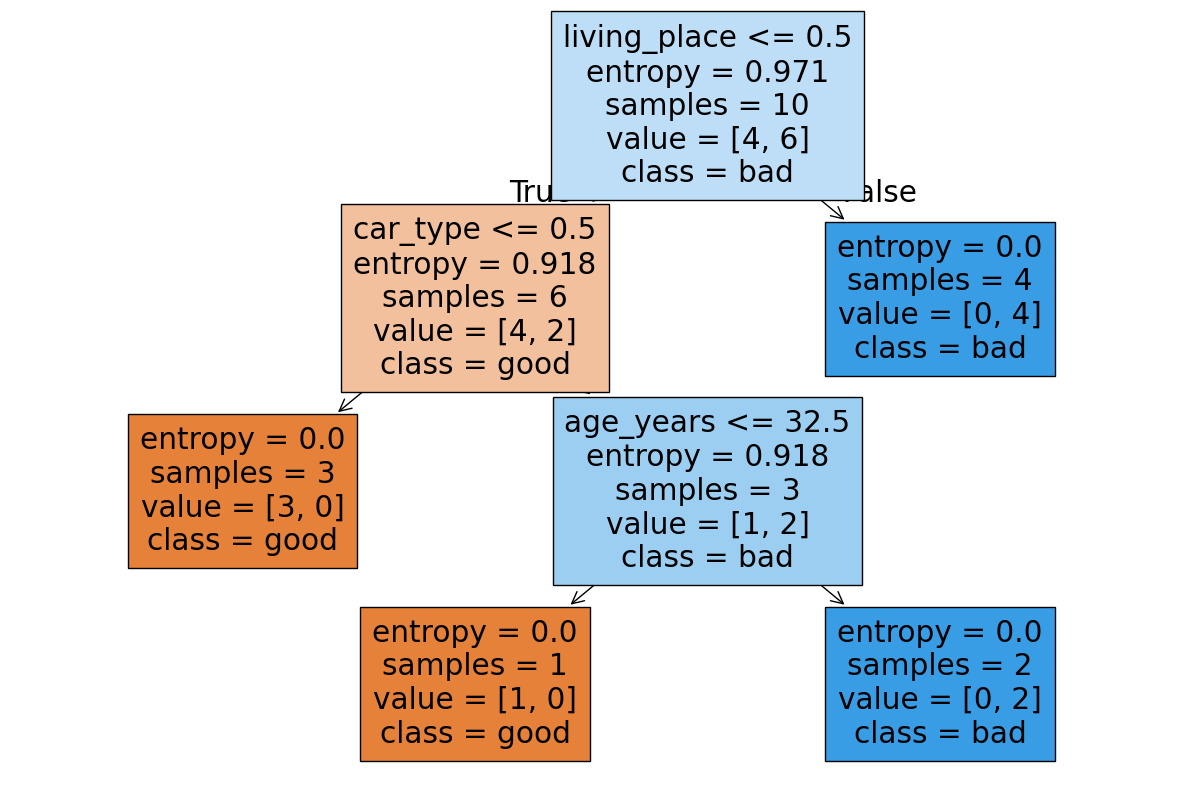

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15,10))
_ = (
    tree.plot_tree(
        clf,
        feature_names=feature_cols,
        class_names=y_labels,
        filled=True
    )
)

Что можно видеть на визуализации
* `value` - сколько объектов каждого класса в узле. На первом этапе 4 объекта одного класса и 5 объектов другого - см. `.value_counts()` немного выше
* в каждом узле считается энтропия
* цветом закодировано количество объектов класса в сплите

## Как производить разбирение

### Энтропия

Пусть система находится в $n$  возможных состояниях. Тогда энтропия данных $X$ вычисляется по формуле

$$
H(X) = - \sum_{i=1}^{n} p_i\log_2(p_i)
$$

Для случая, когда решаем задачу бинарной классфикации $p_0$ - вероятность принадлежности объекта к "негативному" классу и $p_1$ - вероятность принадлежности объекта к "позитивному" классу. Тогда возможных состояний всего два и формула приобретает вид

$$
H(X) = - p_0\log_2(p_0) - p_1\log_2(p_1)
$$

Когда делаем сплит и разделяем выборку $X$ из $N$ элементов на две части $X_{\text{one}}$ и $X_{\text{two}}$ то энтропия считается в каждой подвыборке отдельно
$$
H_{\text{split}}(X) = \frac{N_{\text{one}}}{N}H(X_{\text{one}}) + \frac{N_{\text{two}}}{N}H(X_{\text{two}})
$$

Для любого разбиения по признаку $Q$ можем посчитать прирост информации (information gain):
$$
\text{IG}(Q) = H(X) - H_{\text{split}}(X)
$$

Мы строим дерево чтобы снизить неопределённость - на каждом шаге достаточно выбирать такой порог и признак, чтобы получить максимальный выигрыш информации.

### Задача

Фича *living_place* принимает только категориальные значения (см. выше). Посчитайте энтропию исходного набора данных и при пороге разбиения $0.5$. Будем считать что позитивный лейбл с вероятностью $p_1$ это класс **good**

Для вычисления энтропии используйте [numpy.log2](https://numpy.org/doc/stable/reference/generated/numpy.log2.html#numpy.log2)

Округление результата выполните в виде

```python
ROUND_PRECISION = 2
print(np.round(H_before - H_after, ROUND_PRECISION))
```

In [11]:
SPLIT_THRESHOLD = 0.5

df1_split = df[X['living_place'] <= SPLIT_THRESHOLD]
df2_split = df[X['living_place'] > SPLIT_THRESHOLD]

# --------- ВАШ КОД ТУТ --------
def entropy(p1):
  """p1 - вероятность позитивного класса. Сразу учтите случаи, когда вероятность позитивногокласса равна единице, нулю"""
  res = 1.0
  return res

def eval_p1(input_df):
  """Вспомогательная функция вероятность позитивного класса

    найдите сколько строк попадает под условие 'insurance case'== 'good'
    разделите на общее количество строк
  """
  res = 0.0
  return res


split_share_1 = 1.0
split_share_2 = 0.0
entropy_splt_1 = 0.0
entropy_splt_2 = 1.0



# --------------------------------
H_after = split_share_1*entropy_splt_1 + split_share_2*entropy_splt_1
H_before = entropy(eval_p1(df))

print('entropy: %.2f ', (np.round(H_before - H_after, 2)))

entropy: %.2f  1.0


In [12]:
np.round(H_before - H_after, 2)

np.float64(1.0)

## Градиентный бустинг

### Gradient boosting machine



Попробуем реализовать алгоритм градиентного бустинга (GBM) для задачи регрессии

In [13]:
import pandas as pd

raw_data_file = os.path.join(root_data_dir, 'boosting_toy_dataset.csv')
df = pd.read_csv(raw_data_file)

df.head()

,feature_0,feature_1,feature_2,y
0,-1.012831,-0.562288,0.314247,-73.903672
1,-0.234153,1.523030,-0.234137,111.287982
2,-0.600639,0.375698,-0.291694,1.512835
3,-1.913280,0.241962,-1.724918,-96.663483
4,0.767435,1.579213,-0.469474,145.064623


На фичах будем постоянно обучаться поэтому сохраним их в отдельную переменную

In [14]:
feature_cols = ['feature_0', 'feature_1', 'feature_2']

Нулевое приближение в виде среднего `y.mean()` - это наш самый слабый предсказатель, будем его итеративно улучшать

In [15]:
df['y_hat_0'] = df['y'].mean()
df.head()

,feature_0,feature_1,feature_2,y,y_hat_0
0,-1.012831,-0.562288,0.314247,-73.903672,-15.885802
1,-0.234153,1.523030,-0.234137,111.287982,-15.885802
2,-0.600639,0.375698,-0.291694,1.512835,-15.885802
3,-1.913280,0.241962,-1.724918,-96.663483,-15.885802
4,0.767435,1.579213,-0.469474,145.064623,-15.885802


<Axes: >

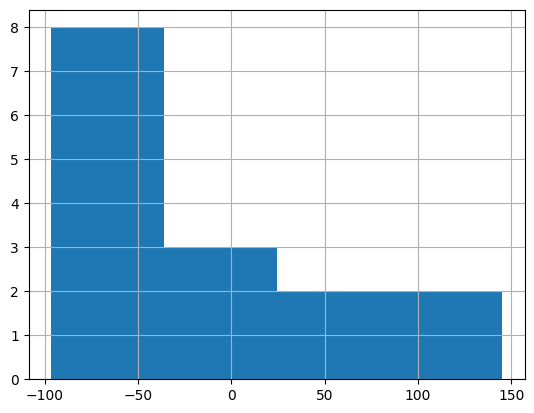

In [16]:
df['y'].hist(bins=4)

Чтобы узнать, "куда бустить" включаем наши знания о градиентах. Функкция потерь у нас такая же как в линейной регрессии (вспоминаем лекцию)
$$
L(y_i, F(x_i)) = \frac{1}{2}\left( y_i - \hat{y}_i\right)^2
$$

Бустить мы хотим сами регрессоры, поэтому и градиеент мы идем прямо по предсказаниям в каждой точке $i$ для итерации $1$ и всех последующих. Вычисляем со знаком "минус" т.к. нужен анти-градиент.
$$
r_{i1} = -\frac{\partial L(y, F(x_i))}{\partial\hat{y}_i} = -(-1)\frac{1}{2}2\left( y - \hat{y}\right)
$$

Мы выкидываем "двойку" - это постоянный множитель, дополнительной информации он не несёт и вычисляем столбец с псеводоостатками, который назовём `resudals`. Мину пропадает, т.к. считаем антиградиент

In [17]:
df['y_resudal_1'] = df['y'] - df['y_hat_0']
df.head()

,feature_0,feature_1,feature_2,y,y_hat_0,y_resudal_1
0,-1.012831,-0.562288,0.314247,-73.903672,-15.885802,-58.017870
1,-0.234153,1.523030,-0.234137,111.287982,-15.885802,127.173784
2,-0.600639,0.375698,-0.291694,1.512835,-15.885802,17.398636
3,-1.913280,0.241962,-1.724918,-96.663483,-15.885802,-80.777681
4,0.767435,1.579213,-0.469474,145.064623,-15.885802,160.950425


Строим новый базовый регрессор $h_1(x)$. Предсказываем псевдо-остатки с предыдущего шага.

In [18]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree_1 = DecisionTreeRegressor(max_depth=1)
targret_resudal = 'y_resudal_1'
tree_1.fit(df[feature_cols], df[targret_resudal])

DecisionTreeRegressor(max_depth=1)

Делаем предикт псевдо-остатков с помощью базового регрессора

In [19]:
df['resudal_predict_1'] = tree_1.predict(df[feature_cols])

Последний шаг - бустим предикшн
* по фичам предсказываем ошибку
* добавляем к базовому предикту предкит ошибки $y = \hat{y}_0 + \gamma h_1(x)$
* $\gamma$ - это *learning rate* в лекци он адаптивный, но для простоты можно использовать константный

In [20]:
gamma = 0.01

df['y_hat_1'] = df['y_hat_0'] + gamma*df['y_resudal_1']
df.head()

,feature_0,feature_1,feature_2,y,y_hat_0,y_resudal_1,resudal_predict_1,y_hat_1
0,-1.012831,-0.562288,0.314247,-73.903672,-15.885802,-58.017870,-35.424637,-16.465980
1,-0.234153,1.523030,-0.234137,111.287982,-15.885802,127.173784,97.417752,-14.614064
2,-0.600639,0.375698,-0.291694,1.512835,-15.885802,17.398636,-35.424637,-15.711815
3,-1.913280,0.241962,-1.724918,-96.663483,-15.885802,-80.777681,-35.424637,-16.693578
4,0.767435,1.579213,-0.469474,145.064623,-15.885802,160.950425,97.417752,-14.276297


Ура! сделали первую итерацию бустинга, дальше можно упаковать в цикл чтобы посчитать $\hat{y_2}, \hat{y_3}, \ldots$. В цикле нужно будет сохранить все деревья обученные на псевдоостатках - потом будем делать предикт.

Т.к. менятся ошибка, то и деревья будут разными.

Для уверенности проверим, что нам удалось уменьшить ошибку

In [21]:
from sklearn.metrics import mean_absolute_error

print('iteration_0: %.4f' % mean_absolute_error(df['y'], df['y_hat_0']))  # константное предсказание
print('iteration_1: %.4f' %  mean_absolute_error(df['y'], df['y_hat_1']))

iteration_0: 66.9535
iteration_1: 66.2839


Победа, ошибка немного но уменьшилась. Следующими интерациями можно будет ещё сильнее забустить предсказания и уменьшить ошибку

Можно делать хоть 10 деревьев, хоть 100 - точное число нужно на кросс-валидации подобрать

<Axes: >

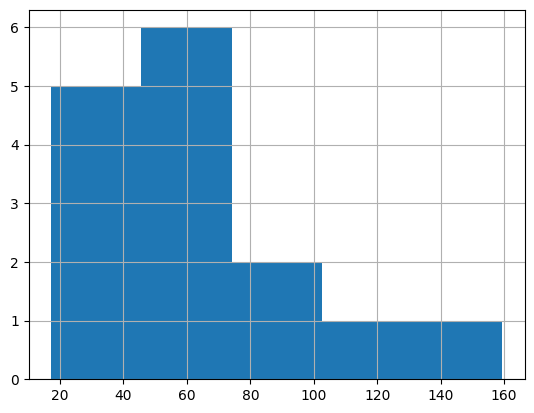

In [22]:
np.sqrt((df['y'] - df['y_hat_1'])**2).hist(bins=5)

Посмотрим, какое дерево обучилось на остатках.

Такое дерево называется "пень" (stomp)

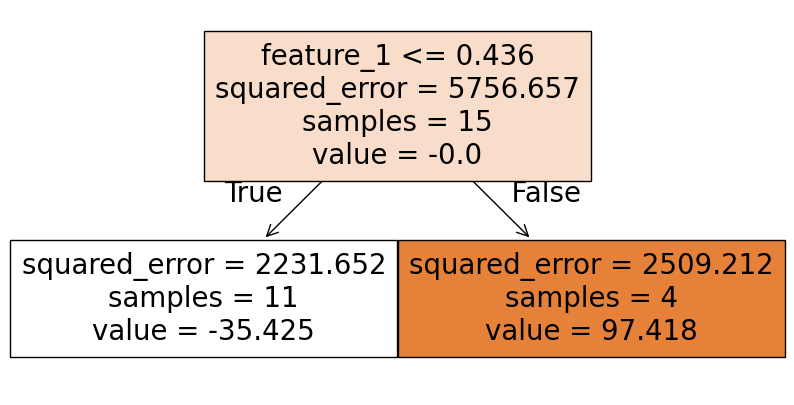

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,5))
_ = (
    plot_tree(
        tree_1,
        feature_names=feature_cols,
        filled=True
    )
)

Как и ожидалось - очень слабенькое дерево, которое предсказывает просто два значения.

Для сплита была выбрана вторая фича